# Protein-Membrane MD Analysis tutorial using BioExcel Building Blocks (biobb)

***
This tutorial aims to illustrate the process of **analyzing a membrane molecular dynamics (MD) simulation** using the **BioExcel Building Blocks library (biobb)**. The particular example used is the heteropentameric ligand-gated chloride channel gated by gamma-aminobutyric acid (**GABA**), a major inhibitory neurotransmitter in the brain, which was embedded in a **DPPC membrane** in the [MemProtMD](https://memprotmd.bioch.ox.ac.uk/_ref/PDB/4cof/_sim/4cof_default_dppc/) project, which trajectory is obtained from the [**MDDB**](https://mddbr.eu/), where we can find it under the [A01M6](https://irb.mddbr.eu/#/id/A01M6/overview) accession id.
***

## Settings

### Biobb modules used

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_mem](https://github.com/bioexcel/biobb_mem): Tools for membrane analysis and manipulation.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 
### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
* [anywidget](https://anywidget.dev/en/getting-started/): Toolset for authoring reusable web-based widgets for interactive computing environments.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_mem.git
cd biobb_wf_mem
conda env create -f conda_env/environment.yml
conda activate biobb_wf_mem
jupyter-notebook biobb_wf_mem/notebooks/biobb_wf_mem.ipynb
```

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Fetching Structure and Trajectory](#fetch)
 3. [Membrane Identification with FATSLiM](#fatslim)
 4. [Density Profile](#density)
 5. [Leafleats Assignation](#leaflets)
 6. [Z Positions and Membrane Thickness](#thickness)
 7. [Channel Dimensions](#channel)
 8. [Questions & Comments](#questions)

***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


In [1]:
# TO BE REMOVED!!!

%load_ext autoreload
%autoreload 2

<a id="input"></a>
## Input parameters

**Input parameters** needed:
 - **MD_id**: MDDB id of the protein trajectory (e.g. [A01M6](https://mmb-dev.mddbr.eu/#/id/A01M6/overview)).
- **steps**: number of frames to skip during analysis.
 - **lipid_sel**: a [MDAnalysis selection](https://docs.mdanalysis.org/stable/documentation_pages/selections.html) of the membrane headgroups on the topology.
 - **ngl_sel**: and **ngl_hd_sel**: [NGLView](http://nglviewer.org/ngl/api/manual/selection-language.html) selection to visualize the membrane.
 - **cpptraj_sel**: [cpptraj](https://amberhub.chpc.utah.edu/cpptraj/) (Ambertools) selection to visualize the membrane.

In [36]:
# Common imports
import os, requests
import pandas as pd
import nglview as nv
import MDAnalysis as mda
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import HBox

MD_id = 'A01M6'
#MD_id = 'A023U'
#MD_id = 'A023W'
#MD_id = 'A023P'
#MD_id = 'A023R'
#steps = 1500 # zpositions tarda nada, pero hole tarda bastante. Considerar poner dos variables: step_z, step_hole.
steps = 1
lipid_sel = '(resname DPPC and name P8)'
ngl_sel = 'DPPC'
cpptraj_sel = 'DPP'
ngl_hd_sel = f'{ngl_sel} and _P'

# Common arguments for all the components
input_top_path = f'data/{MD_id}.pdb'
input_traj_path = f'data/{MD_id}.xtc'

# If you want to disable the logs, set this variable to True    
disable_logs = True

For the **lipid_sel**, we not only choose the residues with name **DPPC**, but also the atom named **P8**, as this is the most charged one. Selecting only the **headgroups** make easier for the algorithms to separate the components of the **membrane**. 

<div style="text-align: center;">
    <img src="img/DPPC.png" alt="DPPC" width="800"/>
</div>

***
## Fetching structure and trajectory

Download the structure and trajectory data, in **PDB** and **XTC** formats respectively, from the MD using the [MDDB API](https://mmb-dev.mddbr.eu/api/rest/docs/).
***
**Building Blocks** used:
 - [mddb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.mddb) from **biobb_io.api.mddb**
***

In [37]:
# Check if folders 'out' and 'data' exist and create them if not
for folder in ['out', 'data']:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")

# Check if PDB and XTC files already exist
pdb = f"data/{MD_id}_10.pdb"
xtc = f"data/{MD_id}_10.xtc"
if not os.path.exists(pdb) or not os.path.exists(xtc):
    
    # Download trajectory
    # Import module
    from biobb_io.api.mddb import mddb

    # Create properties dict and inputs/outputs
    prop = {
        'node_id' : 'irb-dev',
        'project_id': MD_id,
        'trj_format': 'xtc',
        #'frames' : '1:-1:10'
        'frames' : '1:-1:100'
    }

    # Create and launch bb
    mddb(output_top_path=pdb,
         output_trj_path=xtc,
         properties=prop)

### Visualizing trajectory
Visualizing the downloaded **membrane-system trajectory** using **mdanalysis** and **NGL**:  

In [38]:
# Load the trajectory
u = mda.Universe(pdb, xtc)

# Visualize the trajectory
view_mem = nv.show_mdanalysis(u)
view_mem.layout.width = '100%'
view_mem.clear_representations()
view_mem.add_representation('cartoon', selection='all')

# Visualize only the lipids (orange) with the headgroups highlighted (red)
view_mem.add_representation('licorice', selection=ngl_sel, color='orange') # lipids
view_mem.add_representation('spacefill', selection=ngl_hd_sel, color='red', radius=0.9) # headgroups

view_mem.layout.height = '500px'
view_mem.camera='orthographic'
view_mem

NGLWidget(layout=Layout(height='500px', width='100%'), max_frame=1000)

***
## Fitting the membrane

**Membrane analyses** typically assume that the **membrane** system is **aligned** with the **xy plane** and the **thickness** with the **z axis**.

<div style="text-align: center;">
    <img src="img/membrane_placement2.png" alt="Membrane Placement" width="400"></img>
</div>

In this example, **BioBB GROMACS** tools are used to properly **align** the system. 

***
**Building Blocks** used:
 - [GMXImage](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_image) from **biobb_analysis.gromacs.gmx_image** 
***

In [39]:
# We fit the trajectory to the membrane so the z axis is aligned with the membrane
# Import module
from biobb_analysis.gromacs.gmx_image import gmx_image

# Create properties dict and inputs/outputs
memb_fit = 'data/fit.xtc'

prop = {
    'fit_selection': 'DPPC',
    'output_selection': 'System',
    'center': False,
    'fit': 'rot+trans'
}

# Create and launch bb
gmx_image(input_traj_path=xtc,
            input_top_path=pdb,
            output_traj_path=memb_fit,
            properties=prop)

2025-07-09 17:40:04,535 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_image Version: 5.1.0
2025-07-09 17:40:04,536 [MainThread  ] [INFO ]  /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_58a96a88-dd3f-4c34-b21f-73d89c4e721c directory successfully created
2025-07-09 17:40:05,990 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/data/A01M6_10.xtc to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_58a96a88-dd3f-4c34-b21f-73d89c4e721c
2025-07-09 17:40:06,045 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/data/A01M6_10.pdb to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_58a96a88-dd3f-4c34-b21f-73d89c4e721c
2025-07-09 17:40:06,047 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/45ec05c8-b622-4543-a616-3c505910ba07.stdin to 

0

In [40]:
# We fit again transxy to the protein so it does not shake due to lipids going through the pbc

memb_fit_xy = 'data/fit2.xtc'

# Create properties dict and inputs/outputs
prop = {
    'fit_selection': 'Backbone',
    'output_selection': 'System',
    'center': False,
    'fit': 'transxy'
}

# Create and launch bb
gmx_image(input_traj_path=memb_fit,
            input_top_path=pdb,
            output_traj_path=memb_fit_xy,
            properties=prop)

2025-07-09 17:40:14,936 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_image Version: 5.1.0
2025-07-09 17:40:14,938 [MainThread  ] [INFO ]  /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_944b962d-4b8c-489a-98e7-5299b1469138 directory successfully created
2025-07-09 17:40:15,714 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/data/fit.xtc to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_944b962d-4b8c-489a-98e7-5299b1469138
2025-07-09 17:40:15,727 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/data/A01M6_10.pdb to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_944b962d-4b8c-489a-98e7-5299b1469138
2025-07-09 17:40:15,730 [MainThread  ] [INFO ]  Copy: /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/93988235-bcbb-4302-b53a-de63614e9560.stdin to /User

0

<a id="fatslim"></a>
***
## Membrane identification with FATSLiM & Lipyphilic

**Membrane** and **leaflets** automatic identification.<br>
**Biological membranes** (e.g. cell membranes) are typically made up of a **phospholipid bilayer**. This **bilayer** consists of two layers (or **leaflets**) of **lipid molecules**:

- **Outer leaflet**: Faces the **extracellular environment** (outside the cell)

- **Inner leaflet**: Faces the **cytoplasm** (inside the cell)

Each **leaflet** can be composed of various **lipids**, **proteins**, and **carbohydrates**. <br>

**FATSLiM** and **Lipyphilic** tools help us to automatically identify the **leaflets**.
***
**Building Blocks** used:
 - [FatslimMembranes](https://biobb-mem.readthedocs.io/en/latest/fatslim.html#module-fatslim.fatslim_membranes) from **biobb_mem.fatslim.fatslim_membranes**
 - [LPPAssignLeaflets](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_assign_leaflets) from **biobb_mem.lipyphilic_biobb.lpp_assign_leaflets**
***

### FATSLiM leaflets identification
**FATSLiM** automatically identifies **membrane leaflets** and generates a **GROMACS** index file with this information.

In [41]:
# Import module
# Analysis function
from biobb_mem.fatslim.fatslim_membranes import fatslim_membranes

# Create properties dict and inputs/outputs
leaflets_ndx = "out/leaflets.ndx"

prop = {
    'selection': lipid_sel,
    'cutoff': 2.2,
    'ignore_no_box': True,
    #'disable_logs': disable_logs
}

# Create and launch bb
fatslim_membranes(input_top_path=pdb,
                  #input_traj_path=memb_fit_xy,
                  input_traj_path=xtc,
                  output_ndx_path=leaflets_ndx,
                  properties=prop)

2025-07-09 17:40:24,472 [MainThread  ] [INFO ]  Module: biobb_mem.fatslim.fatslim_membranes Version: 5.1.0
2025-07-09 17:40:24,473 [MainThread  ] [INFO ]  /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e0af9cf1-8779-4845-9681-f6224564be2d directory successfully created
2025-07-09 17:40:24,490 [MainThread  ] [INFO ]  Copy: data/A01M6_10.pdb to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e0af9cf1-8779-4845-9681-f6224564be2d
2025-07-09 17:40:26,003 [MainThread  ] [INFO ]  Copy: data/A01M6_10.xtc to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e0af9cf1-8779-4845-9681-f6224564be2d
Setting box dimensions using the minimum and maximum positions of the atoms.
2025-07-09 17:40:26,295 [MainThread  ] [INFO ]  gmx editconf -f /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_e0af9cf1-8779-4845-9681-f6224564be2d/A01M6_10.pdb -o 3252db88-f8a4-4d00-964a-14f44b9ffe0f/ou

0

### Extract leaflets
The previous function generated a **GROMACS** index file (ndx). To extract the **lipids** in each **leaflet** from this file, we can use the <code>parse_index</code> auxiliary function.
These **atom indexes** can be used to select the **lipids** in the **membrane**. 

In [151]:
from biobb_mem.fatslim.fatslim_membranes import parse_index

leaflets_dict = parse_index(leaflets_ndx)

for leaflet in leaflets_dict.keys():
    print(f"Leaflet found: {leaflet}")
    #print(f"Atoms:  {leaflets_dict[leaflet]}")

Leaflet found: membrane_1_leaflet_1
Leaflet found: membrane_1_leaflet_2


### Visualizing leaflets
Visualizing the automatically identified **leaflets**.<br>
Note that there is one **lipid** that is not in a **leaflet** (red coloured). This analysis can be then used as a **quality check** or in case we may want to ignore this **lipid** for the rest of the analyses.

In [152]:
view = nv.show_structure_file(pdb)
view.clear_representations()
view.add_representation('cartoon', selection='all')
view.add_representation('licorice',selection=leaflets_dict['membrane_1_leaflet_1'], color='blue') # leaflet 1
view.add_representation('licorice',selection=leaflets_dict['membrane_1_leaflet_2'], color='cyan') # leaflet 2
view.add_representation('spacefill',selection=ngl_hd_sel, color='red', radius=0.9) # headgroups
#view.add_representation('spacefill',selection='2240', color='red') # lipid outlier
view.layout.height = '500px'
view

NGLWidget(layout=Layout(height='500px'))

### Lipyphilic leaflets identification
**Lipyphilic** assumes a **plane membrane**, is able to assign leafleats for **every frame** and use this information for **flip-flop** analysis.<br>

In [29]:
# Import module
from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets import lpp_assign_leaflets

# Create properties dict and inputs/outputs
prop = {
    'lipid_sel': lipid_sel,
    #'steps': 10,
    'steps': steps,
    #'disable_logs': disable_logs
}

# Create and launch bb
lpp_assign_leaflets(input_top_path=pdb,
                    input_traj_path=memb_fit_xy,
                    output_leaflets_path= 'out/leaflets_data.csv',
                    properties=prop)

2025-07-09 17:36:06,661 [MainThread  ] [INFO ]  Module: biobb_mem.lipyphilic_biobb.lpp_assign_leaflets Version: 5.1.0
2025-07-09 17:36:06,662 [MainThread  ] [INFO ]  /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_76a78a42-9104-4847-971b-1b5958e8540b directory successfully created
2025-07-09 17:36:06,667 [MainThread  ] [INFO ]  Copy: data/A023P_10.pdb to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_76a78a42-9104-4847-971b-1b5958e8540b
2025-07-09 17:36:06,935 [MainThread  ] [INFO ]  Copy: data/fit2.xtc to /Users/hospital/BioBB/Notebooks_dev/biobb_wf_mem/biobb_wf_mem/notebooks/sandbox_76a78a42-9104-4847-971b-1b5958e8540b


ValueError: zero-size array to reduction operation minimum which has no identity

### Visualizing leaflets
Visualizing the automatically identified **leaflets**.<br>

In [154]:
# Leaflets visualization
from biobb_mem.lipyphilic_biobb.lpp_assign_leaflets import display_nglview
view = display_nglview(pdb, 'out/leaflets_data.csv')
view.control.spin([0, 1, 0], -1.57)
view

NGLWidget()

<a id="thickness"></a>
***
## Z positions and membrane thickness

Calculating the **z distance** of **lipids** to the **bilayer center**.<br>
**Membrane thickness** and **local distortion** can be extracted from the **z-position** data. This information can also be used to compare **membrane thickness** in different regions, such as areas in contact with the **protein** versus the rest of the membrane.
***
**Building Blocks** used:
 - [LPPZPositions](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_zpositions) from **biobb_mem.lipyphilic_biobb.lpp_zpositions**
***

### Selecting protein-membrane region

Selecting the **membrane area** in contact with the **protein**.

In [155]:
# We use MDAnalysis to select a region around the protein
# https://docs.mdanalysis.org/stable/documentation_pages/selections.html#geometric
around_sel = '(cyzone 50 70 -50 protein)'
around_resnums = u.select_atoms(around_sel).resnums
# Visualization of the selection in green
view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_point(selection=ngl_sel, color='red')
view.add_point(selection=f'({", ".join(map(str, around_resnums))}) and not protein', color='green')
view.add_point(selection='protein', color='blue')
view

NGLWidget(max_frame=1000)

### Computing z-distances
Computing **z-positions** for both: **whole membrane** and the membrane region in contact with the **protein**

In [156]:
# Run the analysis on the whole membrane
# Import module
from biobb_mem.lipyphilic_biobb.lpp_zpositions import lpp_zpositions

# Create properties dict and inputs/outputs
prop = {
    'lipid_sel': lipid_sel,
    #'steps': 1,
    'steps': steps,
    'height_sel': lipid_sel,
    'ignore_no_box': True,
    'disable_logs': disable_logs
}

# Create and launch bb
lpp_zpositions(input_top_path=pdb,
            input_traj_path=memb_fit_xy,
            output_positions_path='out/zpositions.csv',
            properties=prop)

0

In [157]:
# Run the analysis on the selection around the protein

# Create properties dict and inputs/outputs
prop = {
    'lipid_sel': lipid_sel,
    #'steps': 1,
    'steps': steps,
    'height_sel': f'{lipid_sel} and {around_sel}',
    'ignore_no_box': True,
    'disable_logs': disable_logs
}

# Create and launch bb
lpp_zpositions(input_top_path=pdb,
            input_traj_path=memb_fit_xy,
            output_positions_path='out/zpositions_around.csv',
            properties=prop)

0

### Plotting the thickness of the membrane
Mean **z-position** values for the **positive** (upper leaflet) and **negative** (bottom leaflet) sides are plotted, along with the **membrane thickness** calculated as their difference. Solid lines represent the **entire membrane**, while dashed lines indicate the region in contact with the **protein**. The **standard deviation** of the **thickness** is shown as a grey shaded area.

In [158]:
from biobb_mem.lipyphilic_biobb.lpp_zpositions import frame_df
import plotly.graph_objects as go
import pandas as pd

# Load data
grouped = frame_df('out/zpositions.csv')
around = frame_df('out/zpositions_around.csv')

# Create the figure
fig = go.Figure()

# Add traces for each line
fig.add_trace(go.Scatter(y=grouped['mean_positive'], mode='lines', name='Mean Positive', line=dict(color='blue')))
fig.add_trace(go.Scatter(y=around['mean_positive'], mode='lines', name='Mean Positive 5Å around protein', line=dict(color='blue', dash='dash')))

fig.add_trace(go.Scatter(y=grouped['mean_negative'], mode='lines', name='Mean Negative', line=dict(color='red')))
fig.add_trace(go.Scatter(y=around['mean_negative'], mode='lines', name='Mean Negative 5Å around protein', line=dict(color='red', dash='dash')))

fig.add_trace(go.Scatter(y=grouped['thickness'], mode='lines', name='Thickness', line=dict(color='green')))
fig.add_trace(go.Scatter(y=around['thickness'], mode='lines', name='Thickness 5Å around protein', line=dict(color='green', dash='dash')))

# Add shaded area for thickness ± std
fig.add_trace(go.Scatter(
    x=grouped.index.tolist() + grouped.index[::-1].tolist(),
    y=(grouped['thickness'] + grouped['std_thickness']).tolist() + (grouped['thickness'] - grouped['std_thickness'])[::-1].tolist(),
    fill='toself',
    fillcolor='rgba(0, 128, 0, 0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    hoverinfo="skip",
    name='Thickness ± Std'
))

# Update layout
fig.update_layout(
    title='Mean Positive and Negative Z Positions with Thickness',
    xaxis_title='Frame',
    yaxis_title='Z Position (Å)',
    legend=dict(x=1.02, y=0.5, xanchor='left', yanchor='middle'),
    margin=dict(r=200),
    width=900,
    height=500
)

fig.show()


### Representing and animating the local distorsion

The **z-positions** are used to create an **animation** illustrating **lipid displacements** from the **mean distance** for both the **upper** and **bottom leaflets** of the **membrane bilayer**. **Lipids** that are **below** the **mean distance** are colored in **blue**, while those **above** the **mean** are colored in **red**.

In [159]:
# Custom coloring scheme for the lipids with JavaScript
# https://projects.volkamerlab.org/teachopencadd/talktorials/T017_advanced_nglview_usage.html#Custom-coloring-schemes-and-representations
template = """
this.atomColor = function(atom) {
    let zPos = atom.z - %(midplane_z)f;
    let std = %(factor)f * %(std)f;
    let ratio, r, g, b, layerZ;
    
    if (zPos > 0) { // top leaflet
        layerZ = %(top_z)f;
    } else { // bottom leaflet
        layerZ = -1 * %(bot_z)f;
        zPos = -zPos;
    }
    
    if (zPos >= layerZ) { // thickening
        ratio = (zPos - layerZ) / std;
        ratio = Math.min(1, ratio);
        r = Math.floor(255 * (1 - ratio));
        g = Math.floor(255 * (1 - ratio)); 
        b = 255;
    } else { // thinning
        ratio = -(zPos - layerZ) / std;
        ratio = Math.min(1, ratio);
        r = 255;
        g = Math.floor(255 * (1 - ratio));
        b = Math.floor(255 * (1 - ratio));
    }
    return (r << 16) + (g << 8) + b;
}
"""

# Calculate the mean positive and negative (top and bottom leaflets) z positions 
# wrt the midplane of the membrane, and the standard deviation of the thickness.
top_z = grouped['mean_positive'].mean()
bot_z = grouped['mean_negative'].mean()
std   = grouped['std_thickness'].mean()
top_z, bot_z, std

# Calculate the mean z position of midplane wrt the box axis.
midplane_z = [u.trajectory[i].positions[u.select_atoms(lipid_sel).indices].mean(axis=0)[2] for i in range(0, u.trajectory.n_frames, steps)]
def on_frame_change(change):
    frame = change['new']
    # We use the midplane  
    subframe = frame // steps
    js_function_combined = template % {
        'factor': 3, # Factor to increase the color fade
        'midplane_z': midplane_z[subframe],
        'std': std,
        'top_z': top_z,
        'bot_z': bot_z
    }
    # We have to change the color registry name to trigger the update
    nm = "local_dist"+str(frame) # One color per frame
    nv.color.ColormakerRegistry.add_scheme_func(nm, js_function_combined)
    view.update_ball_and_stick(color=nm)

In [160]:
# Play the animation to see the color change
# RED: Thinning, BLUE: Thickening

view = nv.show_mdanalysis(u)
view.clear_representations()
view.add_ball_and_stick(selection=ngl_hd_sel,aspect_ratio=8)
view.add_cartoon(selection='protein', color='grey')
view.layout.height = '500px'
view.background = 'grey'

view.observe(on_frame_change, names=['frame'])
view

NGLWidget(background='grey', layout=Layout(height='500px'), max_frame=1000)

<a id="density"></a>
***
## Density profile

**Membrane density** refers to the spatial distribution of atoms, molecules, or mass within a **lipid bilayer** typically measured along the **membrane normal** (usually the **z-axis**).

**Membrane density** is calculated over the **z-axis** here with **cpptraj** tool from **AmberTools** and using the [AMBER selection masks](https://amberhub.chpc.utah.edu/atom-mask-selection-syntax/).<br>
***
**Building Blocks** used:
 - [CpptrajDensity](https://biobb-mem.readthedocs.io/en/latest/ambertools.html#module-ambertools.cpptraj_density) from **biobb_mem.ambertools.cpptraj_density**
***

In [161]:
# Import module
from biobb_mem.ambertools.cpptraj_density import cpptraj_density

cpptraj_mask = f":{cpptraj_sel} !:{cpptraj_sel} :{cpptraj_sel}@P8"
print(f"CPPTRAJ mask for {{membrane - non-membrane - headgroups}}: {cpptraj_mask}")

# Create properties dict and inputs/outputs
prop = {
    'mask': cpptraj_mask,
    #'steps': 1,
    'steps': steps,
    'disable_logs': disable_logs,
    'remove_tmp': False
    
}

# Create and launch bb
cpptraj_density(input_top_path=pdb,
            input_traj_path=memb_fit_xy,
            output_cpptraj_path='out/density.dat', 
            properties=prop)

CPPTRAJ mask for {membrane - non-membrane - headgroups}: :DPP !:DPP :DPP@P8

cmd_wrapper commnand print: cpptraj -i 93d2f60e-4c91-4ff4-bee8-435a46c57ac7/instructions.in
Executing: cpptraj -i 93d2f60e-4c91-4ff4-bee8-435a46c57ac7/instructions.in...
Exit code: 0



0

### Visualizing system densities

Visualizing the **protein**, **membrane** and **P8 densities** for the system along the **z-axis**. The corresponding molecular structure is displayed using **NGL** in the same orientation as the 2D-plot, allowing for direct spatial comparison between the **structural** and **density** representations.<br>

In [162]:
# NGL viewer
view = nv.show_file(pdb)
df = pd.read_csv(f'out/density.dat', sep='\s+')
labels = ['Membrane','Protein','P8']

# Plotly 2D plot
axis = df.columns[0] # Axis the density was calculated on
cls = df.columns[1:] # Masks used 
fig = make_subplots(rows=1, cols=1, subplot_titles=['Density along z-axis'])

# Iterate over the columns
for i in range(0,len(cls),2): # Density of each mask
    fig.add_trace(go.Scatter(x=df[axis], y=df[cls[i]], mode='lines', name=labels[i // 2]), row=1, col=1)

# Standard deviation
for i in range(1,len(cls)+1,2): 
    # Add a transparent line plot for the standard deviation
    fig.add_trace(go.Scatter(x=df[axis], y=df[cls[i-1]] - df[cls[i]], mode='lines', fill=None, showlegend=False, line=dict(color='rgba(0,0,0,0)')), row=1, col=1)
    fig.add_trace(go.Scatter(x=df[axis], y=df[cls[i-1]] + df[cls[i]], mode='lines', fill='tonexty', name=f'{labels[i // 2]} STD', line=dict(color='rgba(0,0,0,0)'), fillcolor='rgba(0,100,80,0.2)'), row=1, col=1)
    
fig.update_layout(
    xaxis_title='Å', 
    yaxis_title='Density', 
    legend=dict(orientation="h",
        yanchor="bottom", y=-0.5, xanchor="auto",
        entrywidth=0.33, entrywidthmode='fraction',
        traceorder="normal"),
    autosize=True,
    margin=dict(l=40, r=40, t=40, b=40)
)

fig_widget = go.FigureWidget(fig)

# Set the size of the NGL view widget and its orientation
view.control.spin([0, 1, 0], -1.57)  # Same orientation as the plot
view.clear_representations()
view.add_representation('cartoon', selection='all', color='red')
view.add_representation('licorice',selection=leaflets_dict['membrane_1_leaflet_1'], color='blue') # leaflet 1
view.add_representation('licorice',selection=leaflets_dict['membrane_1_leaflet_2'], color='blue') # leaflet 2
view.add_representation('spacefill',selection=ngl_hd_sel, color='green') # headgroups
view.layout.width = '50%'
view._remote_call('setSize', target='Widget', args=['100%', '100%'])
box = HBox([fig_widget, view])

display(box)

    'data': [{'mode': 'lines',
              'name': 'Membrane',
              '…

<a id="channel"></a>
***
## Channel dimensions

A **membrane channel** or **pore** is a **passage** or **opening** formed by a **protein structure** embedded in a **biological membrane**, allowing the **selective movement** of ions, molecules, or other substances across the **membrane**. **Channels** are typically **gated**, meaning they can **open** or **close** in response to specific **signals** (such as changes in voltage, ligand binding, or mechanical stress).

**MDanalysis hole** tool can be used to identify **channels** and analyze **dimensions** and **properties** along them.<br>
***
**Building Blocks** used:
 - **CHECK, READ_THE_DOCS NOT WORKING!**
 - [MDAHole](https://biobb-mem.readthedocs.io/en/latest/mdanalysis_biobb.html#mdanalysis_biobb.mda_hole.MDAHole) from **from biobb_mem.mdanalysis_biobb.mda_hole** 
***

In [163]:
# Import module
from biobb_mem.mdanalysis_biobb.mda_hole import mda_hole

# Create properties dict and inputs/outputs
prop = {
    'select': 'protein',
    #'steps': steps,
    'steps': 10,
    'sample': 0.1,
    'disable_logs': disable_logs
}

# Create and launch bb
mda_hole(input_top_path=pdb,
         #input_traj_path=memb_fit_xy,
         input_traj_path=xtc,
         output_hole_path='out/hole.vmd',
         output_csv_path='out/hole_profile.csv',
         properties=prop)

/opt/anaconda3/envs/biobb_wf_mem_an/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:777: UserWarning:

Unit cell dimensions not found. CRYST1 record set to unitary values.

/opt/anaconda3/envs/biobb_wf_mem_an/lib/python3.11/site-packages/MDAnalysis/coordinates/PDB.py:1154: UserWarning:

Found no information for attr: 'formalcharges' Using default value of '0'

/opt/anaconda3/envs/biobb_wf_mem_an/lib/python3.11/site-packages/MDAnalysis/lib/util.py:599: DeprecationWarning:

This method is deprecated as of MDAnalysis version 2.7.0 and will be removed in version 3.0.0. Please use shutil.which instead.



0

### Plotting channel dimensions

A **2D plot** representing the **pore radius** along the **pore coordinate**, with the bottom representing the **cytoplasm** and the top representing the **extracellular** space.

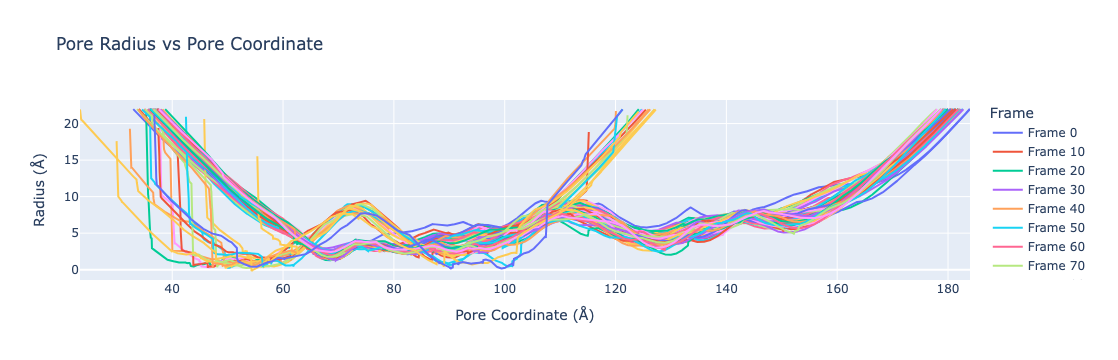

In [164]:
# Load the CSV file
df = pd.read_csv('out/hole_profile.csv')
frames = df['Frame'].unique()

# Create a figure
fig = go.Figure()

# Add traces for each frame
for frame in frames:
    frame_data = df[df['Frame'] == frame]
    fig.add_trace(go.Scatter(x=frame_data['Pore Coordinate'], y=frame_data['Radius'], mode='lines', name=f'Frame {frame}'))

# Update layout
fig.update_layout(
    title='Pore Radius vs Pore Coordinate',
    xaxis_title='Pore Coordinate (Å)',
    yaxis_title='Radius (Å)',
    legend_title='Frame'
)

# Show the figure
fig.show()

### Visualizing channel

In [165]:
from biobb_mem.mdanalysis_biobb.mda_hole import display_hole
display_hole(pdb, memb_fit_xy, output_hole_path='out/hole.vmd', opacity=0.9,frame=0)

/opt/anaconda3/envs/biobb_wf_mem_an/lib/python3.11/site-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning:

Reload offsets from trajectory
 ctime or size or n_atoms did not match



NGLWidget(max_frame=1000)

## Flip-Flop rate
This module provides methods for detecting the **flip-flop** of molecules in a **lipid bilayer**.<br>
A **flip-flop** occurs when a molecule (typically a sterol) moves from one **leaflet** of a **bilayer** into the **opposing leaflet**. This movement can occur spontaneously, although it is generally slow due to the **energy barrier** involved in crossing the **hydrophobic** interior of the **membrane**.<br>
***
**Building Blocks** used:
 - [LPPFlipFlop](https://biobb-mem.readthedocs.io/en/latest/lipyphilic_biobb.html#module-lipyphilic_biobb.lpp_flip_flop) from **from biobb_mem.lipyphilic_biobb.lpp_flip_flop**
***

In [166]:
# Import module
from biobb_mem.lipyphilic_biobb.lpp_flip_flop import lpp_flip_flop

# Create properties dict and inputs/outputs
prop = {
    'lipid_sel': lipid_sel,
    #'steps': 10,
    'steps': steps,
    'frame_cutoff': 2,
    'disable_logs': True
}

# Create and launch bb
lpp_flip_flop(input_top_path=pdb,
              input_traj_path=memb_fit_xy,
              input_leaflets_path='out/leaflets_data.csv',
              output_flip_flop_path='out/flip_flop.csv',
              properties=prop)

  0%|          | 0/594 [00:00<?, ?it/s]

No flip-flop events found.


0

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)
    * [https://github.com/bioexcel/biobb_wf_mem/issues](https://github.com/bioexcel/biobb_wf_mem/issues)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)

* Mail:
    * [ruben.chaves@irbbarcelona.org](mailto:ruben.chaves@irbbarcelona.org)